In [155]:
import numpy as np
import matplotlib.pyplot as plt

In [208]:
# model parameters:
gamma = 3.0
#epsilon = 1E16
#alpha = 3E-8
epsilon = 1E18
alpha = 3E-12
a = np.log(1e-1)
# multiplicity, from Whiteson's fit:
eta  = 0.93
beta = 0.028*(epsilon/1E9)**eta
# guess for now:
lmbda = 200  # m
# minimum detectable flux:
phid = 20

kappa = (phid * 2 * np.pi * lmbda**2 / beta)**(1.0/eta)
Emin = kappa * epsilon
print(f"kappa {kappa:f} Emin:  {Emin:E} eV")

kappa 0.750566 Emin:  7.505663E+17 eV


In [209]:
# shower generation:

def generate_shower_u(*, N=1000000, a):
    global alpha, gamma
    # event weight:
    j_a = (alpha / (gamma - 1.0)) * np.exp((1.0 - gamma)*a)
    w   = j_a / N

    # generate N random variables u
    x = np.random.uniform(0.0, 1.0, N)
    u = a - (1.0 / (gamma - 1.0)) * np.log(1.0 - x)
    
    return u, w

def calculate_E(*, u):
    global epsilon
    return epsilon * np.exp(u)

def calculate_J_E(*, E):
    return alpha / (gamma - 1) * (E / epsilon) ** (1 - gamma)

def calculate_dJdE(*, E):    
    return alpha / epsilon * (E / epsilon) ** (- gamma)

In [210]:
def num_muons(*, E):
    global eta, beta, epsilon
    return beta * (E / epsilon) ** eta

def muon_flux(*, E, r=None):
    global eta, beta, epsilon, lmbda
    phi_zero = beta * (E / epsilon) ** eta / (2 * np.pi * lmbda**2)
    if r is None:
        return phi_zero
    return phi_zero * np.exp(-r / lmbda)

def muon_area(*, E):
    global Emin, eta, lmbda
    # make sure E is a NumPy array
    E = np.asarray(E)
    
    # initialize output array
    area = np.zeros_like(E)
    
    # mask for E > Emin
    mask = E > Emin
    area[mask] = np.pi * lmbda**2 * eta**2 * np.log(E[mask]/Emin)**2
    
    return area


In [211]:
u, w = generate_shower_u(N=1000000, a=a)
E = calculate_E(u=u)

[3.e-08 3.e-10 3.e-12 3.e-14 3.e-16]


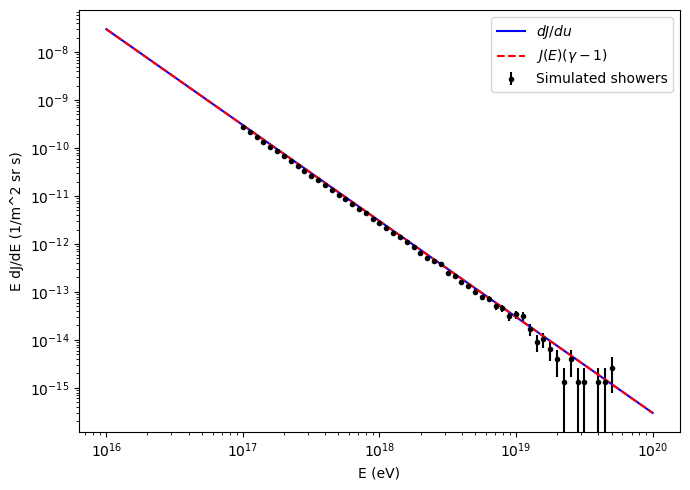

kappa 0.750566 Emin:  7.505663E+17


In [212]:
# calculate histogram and weight by w * E / delta E
bins = np.logspace(16, 20, 80+1)
counts, edges = np.histogram(E, bins=bins)
de = edges[1:] - edges[:-1]
ec = np.sqrt(edges[1:] * edges[:-1])
hist = counts * w * ec / de
sigma = np.sqrt(counts) * w * ec / de

# plot the results:
plt.figure(figsize=(7,5))
plt.errorbar(
    edges[:-1], hist, yerr=sigma, 
    fmt='o', markersize=3, linestyle='none', color="k", label='Simulated showers'
)

# compare to theory curve:
Ef = np.logspace(16, 20, 5)
uf = np.log(Ef / epsilon)
djdu = alpha * np.exp((1.0 - gamma) * uf)  # dJ/du
j = calculate_J_E(E=Ef) * (gamma-1)
print(j)
plt.plot(Ef, djdu, 'b-', label='$dJ/du$')
plt.plot(Ef, j, 'r--', label='$J(E) (\gamma-1)$')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('E (eV)')
plt.ylabel('E dJ/dE (1/m^2 sr s)')
plt.legend()
plt.tight_layout()
plt.show()

Emin = kappa * epsilon
print(f"kappa {kappa:f} Emin:  {Emin:E}")

Ef:   [1.00000000e+14 4.64158883e+14 2.15443469e+15 1.00000000e+16
 4.64158883e+16 2.15443469e+17 1.00000000e+18 4.64158883e+18
 2.15443469e+19 1.00000000e+20]


Text(0, 0.5, 'Number of muons')

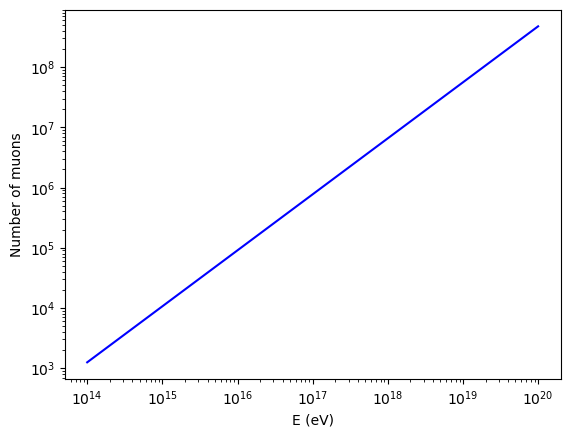

In [213]:
Ef = np.logspace(14, 20, 10)
print("Ef:  ", Ef)
muf = num_muons(E=Ef)
plt.plot(Ef, muf, 'b-', label="muon")

plt.xscale('log')
plt.yscale('log')
plt.xlabel('E (eV)')
plt.ylabel('Number of muons')

Ef:   [1.00000000e+14 4.64158883e+14 2.15443469e+15 1.00000000e+16
 4.64158883e+16 2.15443469e+17 1.00000000e+18 4.64158883e+18
 2.15443469e+19 1.00000000e+20]


Text(0, 0.5, 'Muon Flux')

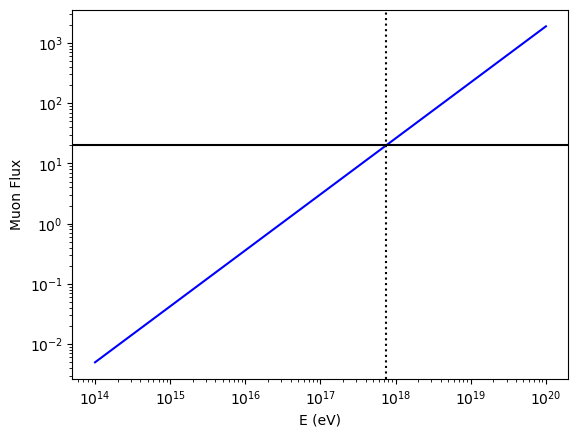

In [214]:
Ef = np.logspace(14, 20, 10)
print("Ef:  ", Ef)
phi = muon_flux(E=Ef)

plt.plot(Ef, phi, 'b-', label="model")
plt.axhline(y=phid, color='k', linestyle='-')
plt.axvline(x=Emin, color='k', linestyle=':')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('E (eV)')
plt.ylabel('Muon Flux')

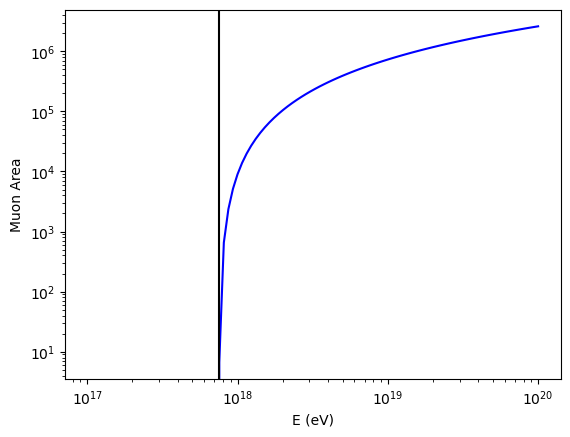

In [215]:
Ef = np.logspace(17, 20, 100)
Ad = muon_area(E=Ef)

plt.plot(Ef, Ad, 'b-', label="model")
plt.axvline(x=Emin, color='k', linestyle='-')
plt.xlabel('E (eV)')
plt.ylabel('Muon Area')
plt.xscale('log')
plt.yscale('log')


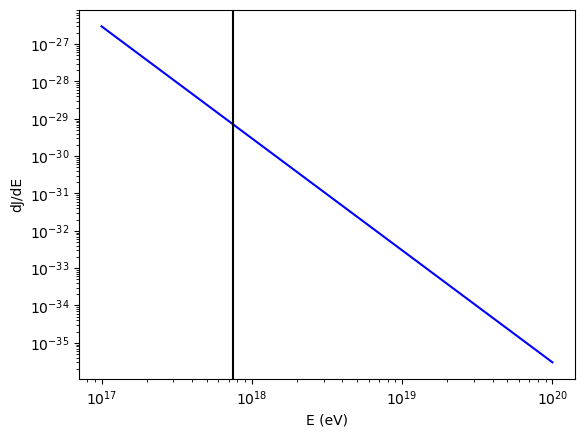

In [216]:
Ef = np.logspace(17, 20, 10)
J = calculate_dJdE(E=Ef)

plt.plot(Ef, J, 'b-', label="model")
plt.axvline(x=Emin, color='k', linestyle='-')
plt.xlabel('E (eV)')
plt.ylabel('dJ/dE')
plt.xscale('log')
plt.yscale('log')


Integrated rate (Hz): 4.5343117020507474e-07
Events Per Year:   14.299405383587237


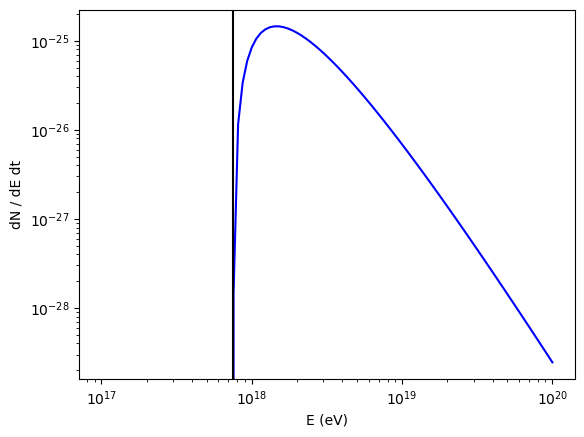

In [217]:
Ef = np.logspace(17, 20, 100)
Ad = muon_area(E=Ef)
J = calculate_dJdE(E=Ef)
Y = np.pi* J * Ad

plt.plot(Ef, Y, 'b-', label="model")
plt.axvline(x=Emin, color='k', linestyle='-')
plt.xlabel('E (eV)')
plt.ylabel('dN / dE dt')
plt.xscale('log')
plt.yscale('log')

total_rate = np.trapz(Y, x=Ef)
events_per_year = total_rate*60*60*24*365
print("Integrated rate (Hz):", total_rate)
print("Events Per Year:  ", events_per_year)

E:    [2.39966129e+17 2.19144985e+17 1.30741552e+17 1.37310652e+17
 1.29204006e+17 1.32619160e+17 2.10955767e+17 9.04160473e+17
 2.35061791e+17 1.49815015e+17]
r:    [2514.05645231 1528.18966873  780.25763917 1724.71239529 1576.89544387
 1120.03925553 2975.18751828 2317.41740371 1901.84235087 1168.23731451]
muf:  [2.40576609e-05 3.05757275e-03 7.95930079e-02 7.40999176e-04
 1.46629004e-03 1.47505314e-02 2.12754408e-06 2.20809904e-04
 5.03870900e-04 1.29834331e-02]


Text(0.5, 0, 'muon flux [/m^2]')

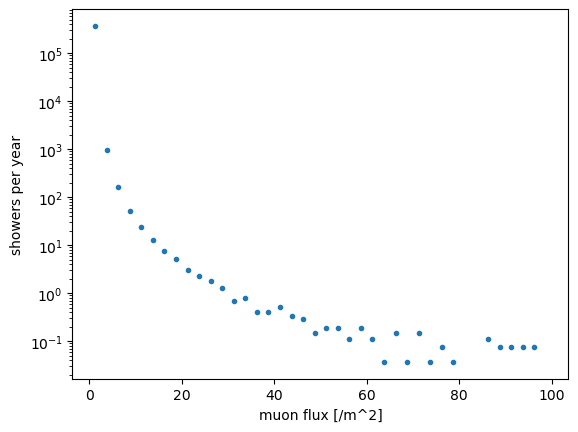

In [218]:
# Monte Carlo Simulation:
N = 10000000
L = 5000
A = L*L

u, w = generate_shower_u(N=N, a=a)
E = calculate_E(u=u)
x = np.random.uniform(-L/2, L/2, N)
y = np.random.uniform(-L/2, L/2, N)
r = np.sqrt(x*x + y*y)
muf = muon_flux(E=E, r=r)
print("E:   ", E[:10])
print("r:   ", r[:10])
print("muf: ", muf[:10])

year = 60 * 60 * 24 * 365
wtot = w * np.pi * L * L * year
counts, edges = np.histogram(muf, 40, range=(0,100))
rate = counts * wtot
rerr = np.sqrt(counts) * wtot
bc = (edges[:-1] + edges[1:])/2
plt.plot(bc, rate, ".")
plt.yscale("log")
plt.ylabel('showers per year')
plt.xlabel('muon flux [/m^2]')



count:  [9966874   25672    4312    1422     645     345     206     141      82
      62      48      34      19      21      11      11      14       9
       8       4       5       5       3       5       3       1       4
       1       4       1       2       1       0       0       3       2
       2       2       2       0]


Text(25, 21.449108075380856, '14.3 events/year')

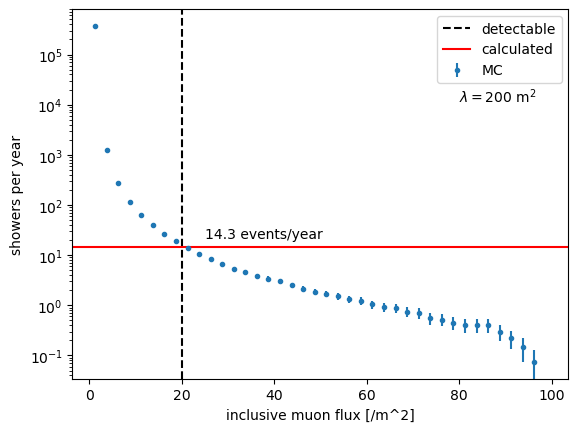

In [219]:
print("count: ", counts)
nbins = np.size(counts)
icounts = np.zeros(nbins)

for i in range(nbins):
    icounts[i] = np.sum(counts[i:])

irate = icounts * wtot
irerr = np.sqrt(icounts) * wtot
ymax  = np.max(irate)
plt.errorbar(x=bc, y=irate, yerr=irerr, fmt=".", label="MC")
plt.yscale("log")
plt.ylabel('showers per year')
plt.xlabel('inclusive muon flux [/m^2]')
plt.axvline(x=phid, color='k', linestyle='--', label="detectable")
plt.axhline(y=events_per_year, color='r', linestyle='-', label="calculated")
plt.legend()
plt.text(80,ymax*0.03, f"$\lambda=${lmbda} m$^2$")
plt.text(phid+5,1.5*events_per_year, f"{events_per_year:0.1f} events/year")
#plt.savefig(f"results_{lmbda}.pdf")

In [64]:
help("numpy.random.uniform")


Help on built-in function uniform in numpy.random:

numpy.random.uniform = uniform(...) method of numpy.random.mtrand.RandomState instance
    uniform(low=0.0, high=1.0, size=None)
    
    Draw samples from a uniform distribution.
    
    Samples are uniformly distributed over the half-open interval
    ``[low, high)`` (includes low, but excludes high).  In other words,
    any value within the given interval is equally likely to be drawn
    by `uniform`.
    
    .. note::
        New code should use the `~numpy.random.Generator.uniform`
        method of a `~numpy.random.Generator` instance instead;
        please see the :ref:`random-quick-start`.
    
    Parameters
    ----------
    low : float or array_like of floats, optional
        Lower boundary of the output interval.  All values generated will be
        greater than or equal to low.  The default value is 0.
    high : float or array_like of floats
        Upper boundary of the output interval.  All values generated wil

In [74]:
help("numpy.histogram")

Help on _ArrayFunctionDispatcher in numpy:

numpy.histogram = histogram(a, bins=10, range=None, density=None, weights=None)
    Compute the histogram of a dataset.
    
    Parameters
    ----------
    a : array_like
        Input data. The histogram is computed over the flattened array.
    bins : int or sequence of scalars or str, optional
        If `bins` is an int, it defines the number of equal-width
        bins in the given range (10, by default). If `bins` is a
        sequence, it defines a monotonically increasing array of bin edges,
        including the rightmost edge, allowing for non-uniform bin widths.
    
        .. versionadded:: 1.11.0
    
        If `bins` is a string, it defines the method used to calculate the
        optimal bin width, as defined by `histogram_bin_edges`.
    
    range : (float, float), optional
        The lower and upper range of the bins.  If not provided, range
        is simply ``(a.min(), a.max())``.  Values outside the range are
      

In [171]:
help("matplotlib.pyplot.errorbar")


Help on function errorbar in matplotlib.pyplot:

matplotlib.pyplot.errorbar = errorbar(x: 'float | ArrayLike', y: 'float | ArrayLike', yerr: 'float | ArrayLike | None' = None, xerr: 'float | ArrayLike | None' = None, fmt: 'str' = '', ecolor: 'ColorType | None' = None, elinewidth: 'float | None' = None, capsize: 'float | None' = None, barsabove: 'bool' = False, lolims: 'bool | ArrayLike' = False, uplims: 'bool | ArrayLike' = False, xlolims: 'bool | ArrayLike' = False, xuplims: 'bool | ArrayLike' = False, errorevery: 'int | tuple[int, int]' = 1, capthick: 'float | None' = None, *, data=None, **kwargs) -> 'ErrorbarContainer'
    Plot y versus x as lines and/or markers with attached errorbars.
    
    *x*, *y* define the data locations, *xerr*, *yerr* define the errorbar
    sizes. By default, this draws the data markers/lines as well as the
    errorbars. Use fmt='none' to draw errorbars without any data markers.
    
    .. versionadded:: 3.7
       Caps and error lines are drawn in pol